In [1]:
import sys
import os

sys.path.append("/Users/mb279434/Documents/stage/repos/argosim/src")

- random configuration 

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from argosim import antenna_utils, imaging_utils, metrics_utils, plot_utils

# Parameters
n_generations = 50
n_antennas = 30
space_size = 4000
mutation_rate = 0.2
n_mutations = 20
d_min = 100.0
fov_size = (0.3, 0.3)
im_size = (256, 256)



def objective(antenna_pos, target_sll=-15.0):
    try:
        b_enu = antenna_utils.get_baselines(antenna_pos)
        track, _ = antenna_utils.uv_track_multiband(
            b_ENU=b_enu, track_time=3, n_times=10, f=1e9, df=1e8, n_freqs=10
        )
        mask, _ = imaging_utils.grid_uv_samples(track, sky_uv_shape=im_size, fov_size=fov_size)
        beam = imaging_utils.uv2sky(mask)
        beam = np.abs(beam) / np.max(np.abs(beam))
        fit = metrics_utils.fit_elliptical_beam(beam.copy(), threshold_ratio=0.2)
        metrics = metrics_utils.compute_beam_metrics(beam)
        sll_score = abs(metrics["sll_db"] - target_sll)
        fwhm_score = 0.1 * (metrics["fwhm"][0] + metrics["fwhm"][1])
        ecc_score = 0.5 * metrics["eccentricity"]
        score = sll_score + fwhm_score + ecc_score
        return score, beam, fit, metrics
    except Exception as e:
        return 1e6, None, None, None

def min_distance(config, d_min=100.0):
    for i in range(len(config)):
        for j in range(i+1, len(config)):
            if np.linalg.norm(config[i] - config[j]) < d_min:
                return False
    return True

def mutate_config(base_config, mutation_rate=0.2, d_min=100.0, max_trials=10):
    for _ in range(max_trials):
        config = base_config.copy()
        for i in range(len(config)):
            if np.random.rand() < mutation_rate:
                config[i] += np.random.normal(0, 100, size=3)
                config[i][2] = 0
        if min_distance(config, d_min=d_min):
            return config
    return base_config

#  Initialization
initial_config = np.array([
    antenna_utils.random_antenna_pos(E_lim=space_size, N_lim=space_size, U_lim=0)
    for _ in range(n_antennas)
])
current_config = initial_config.copy()
best_score, best_beam, best_fit, best_metrics = objective(current_config)

history = {"sll": [best_metrics["sll_db"]], "fwhm_x": [best_metrics["fwhm"][0]], "fwhm_y": [best_metrics["fwhm"][1]], "ecc": [best_metrics["eccentricity"]], "configs": [current_config.copy()]}

#  Optimization loop
for gen in range(n_generations):
    candidates = []
    for _ in range(n_mutations):
        mutated = mutate_config(current_config)
        score, beam, fit, metrics = objective(mutated)
        candidates.append((score, mutated, beam, fit, metrics))
    
    candidates.sort(key=lambda x: x[0])
    best_candidate = candidates[0]

    if best_candidate[0] < best_score:
        best_score, current_config, best_beam, best_fit, best_metrics = best_candidate

    history["configs"].append(current_config.copy())

    history["sll"].append(best_metrics["sll_db"])
    history["fwhm_x"].append(best_metrics["fwhm"][0])
    history["fwhm_y"].append(best_metrics["fwhm"][1])
    history["ecc"].append(best_metrics["eccentricity"])




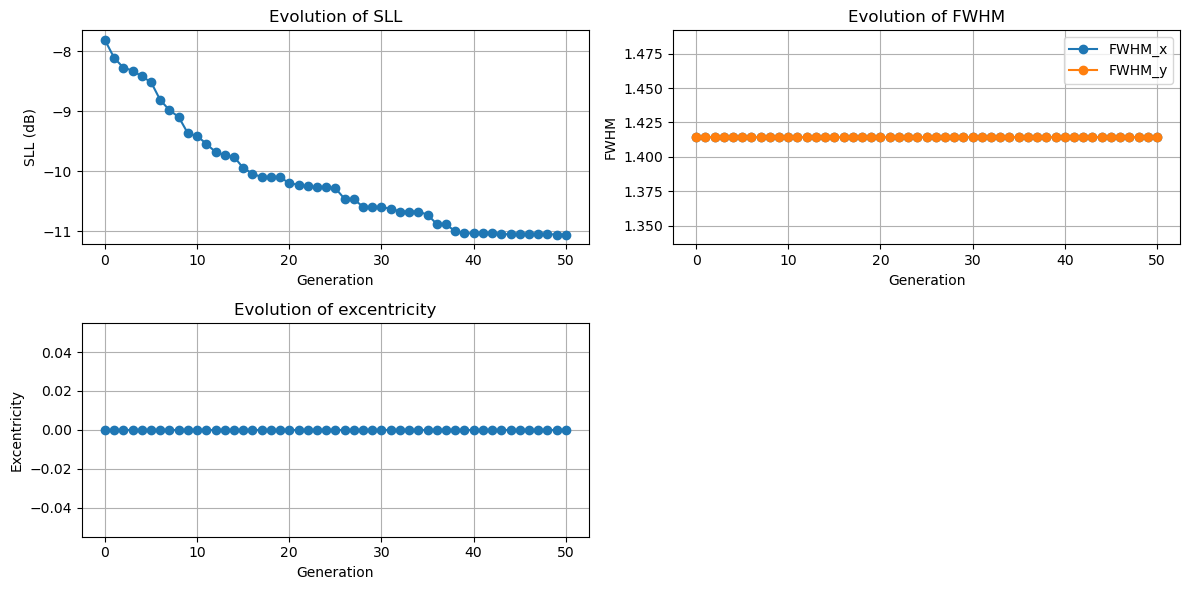

In [ ]:

# Plot the evolution of metrics over generations
generations = list(range(len(history["sll"])))

plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(generations, history["sll"], marker='o')
plt.title("Evolution of SLL")
plt.xlabel("Generation")
plt.ylabel("SLL (dB)")
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(generations, history["fwhm_x"], label="FWHM_x", marker='o')
plt.plot(generations, history["fwhm_y"], label="FWHM_y", marker='o')
plt.title("Evolution of FWHM")
plt.xlabel("Generation")
plt.ylabel("FWHM")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(generations, history["ecc"], marker='o')
plt.title("Evolution of excentricity")
plt.xlabel("Generation")
plt.ylabel("Excentricity")
plt.grid(True)

plt.tight_layout()
plt.show()


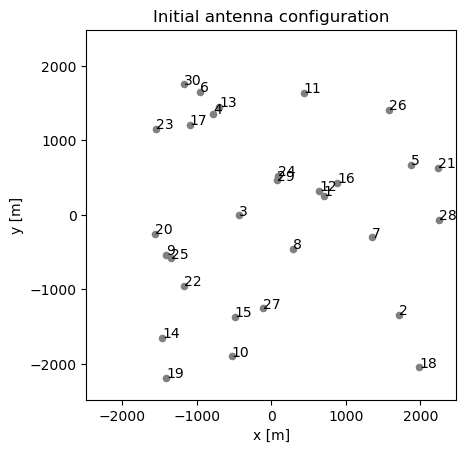

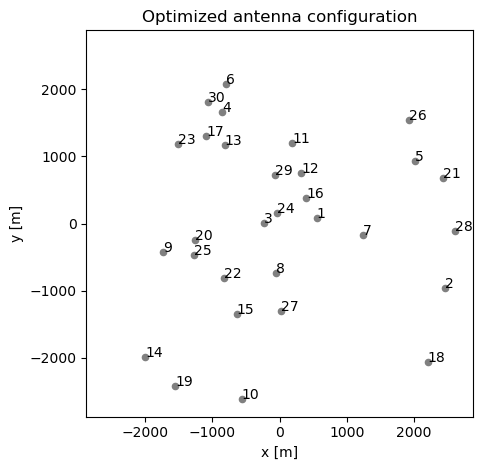

In [ ]:


# Plot the initial antenna configuration
plot_utils.plot_antenna_arr(initial_config,title="Initial antenna configuration")

# Plot the final antenna configuration after optimization
plot_utils.plot_antenna_arr(current_config, title="Optimized antenna configuration")

plt.tight_layout()
plt.show()


- different weights

In [ ]:
def objective(antenna_pos, target_sll=-15.0, w_sll=1.0, w_fwhm=0.1, w_ecc=0.5):
    try:
        b_enu = antenna_utils.get_baselines(antenna_pos)
        track, _ = antenna_utils.uv_track_multiband(
            b_ENU=b_enu, track_time=3, n_times=10, f=1e9, df=1e8, n_freqs=10
        )
        mask, _ = imaging_utils.grid_uv_samples(track, sky_uv_shape=im_size, fov_size=fov_size)
        beam = imaging_utils.uv2sky(mask)
        beam = np.abs(beam) / np.max(np.abs(beam))
        fit = metrics_utils.fit_elliptical_beam(beam.copy(), threshold_ratio=0.2)
        metrics = metrics_utils.compute_beam_metrics(beam)
        
        sll_score = w_sll * abs(metrics["sll_db"] - target_sll)
        fwhm_score = w_fwhm * (metrics["fwhm"][0] + metrics["fwhm"][1])
        ecc_score = w_ecc * metrics["eccentricity"]

        score = sll_score + fwhm_score + ecc_score
        return score, beam, fit, metrics
    except Exception:
        return 1e6, None, None, None


weight_scenarios = [
    {"w_sll": 1.0, "w_fwhm": 0.1, "w_ecc": 0.6},
    {"w_sll": 1.0, "w_fwhm": 0.05, "w_ecc": 0.1},
    {"w_sll": 1.0, "w_fwhm": 0.5, "w_ecc": 0.001}
]

for weights in weight_scenarios:
    current_config = initial_config.copy()
    best_score, best_beam, best_fit, best_metrics = objective(current_config, w_sll=w_sll, w_fwhm=w_fwhm, w_ecc=w_ecc)

    history = {"sll": [best_metrics["sll_db"]],
               "fwhm_x": [best_metrics["fwhm"][0]],
               "fwhm_y": [best_metrics["fwhm"][1]],
               "ecc": [best_metrics["eccentricity"]],
               "score": [best_score]}

    for gen in range(n_generations):
        candidates = []
        for _ in range(n_mutations):
            mutated = mutate_config(current_config)
            score, beam, fit, metrics = objective(mutated, **weights)
            candidates.append((score, mutated, beam, fit, metrics))

        candidates.sort(key=lambda x: x[0])
        best_candidate = candidates[0]

        if best_candidate[0] < best_score:
            best_score, current_config, best_beam, best_fit, best_metrics = best_candidate

        history["sll"].append(best_metrics["sll_db"])
        history["fwhm_x"].append(best_metrics["fwhm"][0])
        history["fwhm_y"].append(best_metrics["fwhm"][1])
        history["ecc"].append(best_metrics["eccentricity"])
        history["score"].append(best_score)

    # Plot
    generations = list(range(len(history["score"])))
    plt.figure(figsize=(14, 4))
    plt.suptitle(f"Test with weights: w_sll={weights['w_sll']}, w_fwhm={weights['w_fwhm']}, w_ecc={weights['w_ecc']}")

    plt.subplot(1, 4, 1)
    plt.plot(generations, history["score"], marker='o')
    plt.title("Score")
    plt.xlabel("Generation")

    plt.subplot(1, 4, 2)
    plt.plot(generations, history["sll"], marker='o')
    plt.title("SLL (dB)")

    plt.subplot(1, 4, 3)
    plt.plot(generations, history["fwhm_x"], label="FWHM_x", marker='o')
    plt.plot(generations, history["fwhm_y"], label="FWHM_y", marker='o')
    plt.title("FWHM")
    plt.legend()

    plt.subplot(1, 4, 4)
    plt.plot(generations, history["ecc"], marker='o')
    plt.title("Eccentricity")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
